In [113]:
# Ref: https://www.kaggle.com/luowenjun/using-conv1d-reach-the-accuracy-98-30-by-pytorch

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import DataLoader
from torch import nn,optim

%matplotlib inline

In [4]:
def my_DataLoader(train_root,test_root,batch_size = 100, val_split_factor = 0.2):

    train_df = pd.read_csv(train_root, header=None)
    test_df = pd.read_csv(test_root, header=None)

    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:, :-1]).float(),
                                                   torch.from_numpy(train_data[:, -1]).long(),)
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_data[:, :-1]).float(),
                                                  torch.from_numpy(test_data[:, -1]).long())

    train_len = train_data.shape[0]
    val_len = int(train_len * val_split_factor)
    train_len -= val_len

    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [5]:
class conv_net(nn.Module):

    def __init__(self, num_of_class):
        super(conv_net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),

        )

        self.linear = nn.Sequential(
            nn.Linear(2944,500),
            nn.LeakyReLU(inplace=True),
            nn.Linear(500, num_of_class),

        )


    def forward(self,x):
        x = x.unsqueeze(1)
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

In [6]:
batch_size=1000
lr = 3e-3
epochs = 50
torch.manual_seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

def evalute(model, loader):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total

def main():

    train_loader, val_loader, test_loader = my_DataLoader('../data/mitbih_train.csv',
                                                          '../data/mitbih_test.csv',
                                                          batch_size=batch_size,
                                                          val_split_factor=0.2)

    model = conv_net(5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criteon = nn.CrossEntropyLoss()

    best_acc, best_epoch = 0, 0
    global_step = 0

    for epoch in range(epochs):

        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, (x, y) in enumerate(train_bar):
            x, y = x.to(device), y.to(device)

            model.train()
            logits = model(x)
            loss = criteon(logits, y)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

            global_step += 1

        if epoch % 1 == 0:

            val_acc = evalute(model, val_loader)
            print('val_acc = ',val_acc)
            if val_acc > best_acc:
                best_epoch = epoch
                best_acc = val_acc

                torch.save(model.state_dict(), 'best.mdl')

    print('best acc:', best_acc, 'best epoch:', best_epoch)

    model.load_state_dict(torch.load('best.mdl'))
    print('loaded from ckpt!')

    test_acc = evalute(model, test_loader)
    print('test acc:', test_acc)


# if __name__ == '__main__':
#     main()

using cpu device.


## Run

In [7]:
# load model states
train_loader, val_loader, test_loader = my_DataLoader('../data/mitbih_train.csv',
                                                      '../data/mitbih_test.csv',
                                                      batch_size=batch_size,
                                                      val_split_factor=0.2)

model = conv_net(5).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criteon = nn.CrossEntropyLoss()

best_acc, best_epoch = 0, 0
global_step = 0

model.load_state_dict(torch.load('best.mdl'))

<All keys matched successfully>

In [37]:
# predict all zeros
loader = test_loader

model.eval()

correct = 0
total = len(loader.dataset)
val_bar = tqdm(loader, file=sys.stdout)
for x, y in val_bar:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = torch.zeros(y.shape)
    correct += torch.eq(pred, y).sum().float().item()
    
test_acc = correct / total
print('test acc:', test_acc)

100%|██████████| 22/22 [00:00<00:00, 144.66it/s]
test acc: 0.8276082587246483


In [38]:
# predict using best model
loader = test_loader

model.eval()

correct = 0
total = len(loader.dataset)
val_bar = tqdm(loader, file=sys.stdout)
for x, y in val_bar:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(dim=1)
    correct += torch.eq(pred, y).sum().float().item()
    
test_acc = correct / total
print('test acc:', test_acc)

100%|██████████| 22/22 [00:03<00:00,  6.15it/s]
test acc: 0.9836469943358305


## Result

In [ ]:
test_df = pd.read_csv('../data/mitbih_test.csv', header=None)
test_data = test_df.to_numpy()

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_data[:, :-1]).float(),
                                              torch.from_numpy(test_data[:, -1]).long())

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
for x, y in test_loader:
    logits = model(x)
    pred = logits.argmax(dim=1)
    true = y

In [154]:
average_metric = 'macro'
print(confusion_matrix(y_true=true, y_pred=pred))
print(f"accuracy: {accuracy_score(true, pred)}")
print(f"precision: {precision_score(true, pred, average=average_metric)}")
print(f"recall: {recall_score(true, pred, average=average_metric)}")
print(f"f1: {f1_score(true, pred, average=average_metric)}")

[[18025    50    29    10     4]
 [  123   423     7     1     2]
 [   50     2  1379    12     5]
 [   20     1    17   123     1]
 [   18     0     6     0  1584]]
accuracy: 0.9836469943358305
precision: 0.9342005383067878
recall: 0.8904680604880933
f1: 0.9109037050332607


## Visualization

In [42]:
train_df = pd.read_csv('../data/mitbih_train.csv', header=None)
test_df = pd.read_csv('../data/mitbih_test.csv', header=None)

In [52]:
label = [0,1,2,3,4]
for i in label:
    print(f'Num of Label {i}: {train_df[train_df[187] == i].shape[0]}')

Num of Label 0: 72471
Num of Label 1: 2223
Num of Label 2: 5788
Num of Label 3: 641
Num of Label 4: 6431


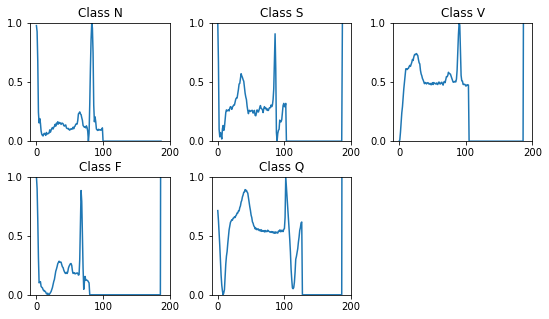

In [217]:
# Ref: https://arxiv.org/pdf/1805.00794.pdf

label = ['N', 'S', 'V', 'F', 'Q']
plt.figure(figsize=(9,5))

for i, j in enumerate(label):
    plt.subplot(2, 3, i+1)
    plt.title(f'Class {j}')
    plt.ylim(0, 1)
    plt.plot(
        np.arange(train_df[train_df[187] == i].iloc[0,:].shape[0]),
        train_df[train_df[187] == i].iloc[0,:])
    plt.xticks([0,100,200])
    plt.yticks([0.0, 0.5, 1.0])

plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [194]:
all_df = pd.concat([train_df, test_df])
labels = ['N', 'S', 'V', 'F', 'Q']
counts = list(np.unique(all_df[187], return_counts=True)[1])

<BarContainer object of 5 artists>

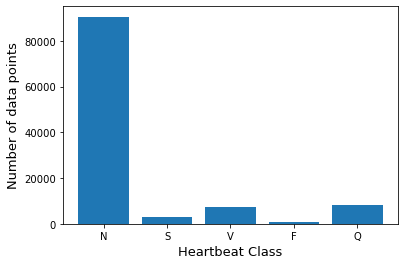

In [237]:
plt.rc('axes', labelsize=13)
plt.xlabel('Heartbeat Class')
plt.ylabel('Number of data points')
plt.bar(labels, counts)